# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

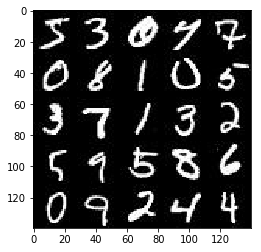

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

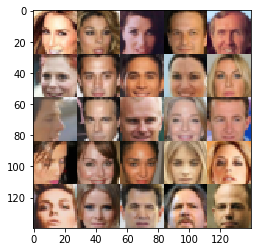

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_inputs")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, keep_prob=0.88):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x = tf.maximum(alpha*x, x)
        #Output 14x14x64
        
        x2 = tf.layers.conv2d(x, 128, 5, strides=2, padding='SAME',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        #Output 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        #Output 4x4x256
        
        logits = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(logits, 1)
        logits = tf.nn.dropout(logits, keep_prob=keep_prob)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding='SAME',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # output 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # output 14x14x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        # output 28x28x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='SAME')
        # output 28x28xoutput_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Generator network
    g_model = generator(input_z, out_channel_dim)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
        
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every=10, show_every=150):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 0.5597... Generator Loss: 7.1928
Epoch 1/4... Discriminator Loss: 0.8251... Generator Loss: 6.3566
Epoch 1/4... Discriminator Loss: 4.0673... Generator Loss: 14.4707
Epoch 1/4... Discriminator Loss: 2.3417... Generator Loss: 0.2666
Epoch 1/4... Discriminator Loss: 1.0829... Generator Loss: 13.3786
Epoch 1/4... Discriminator Loss: 0.5491... Generator Loss: 8.5779
Epoch 1/4... Discriminator Loss: 0.5277... Generator Loss: 3.4760
Epoch 1/4... Discriminator Loss: 0.5104... Generator Loss: 4.4478
Epoch 1/4... Discriminator Loss: 0.9580... Generator Loss: 0.9665
Epoch 1/4... Discriminator Loss: 0.6255... Generator Loss: 5.3916
Epoch 1/4... Discriminator Loss: 0.9751... Generator Loss: 3.9719
Epoch 1/4... Discriminator Loss: 0.8042... Generator Loss: 1.7373
Epoch 1/4... Discriminator Loss: 0.8169... Generator Loss: 1.6705
Epoch 1/4... Discriminator Loss: 0.7328... Generator Loss: 1.6838
Epoch 1/4... Discriminator Loss: 0.9887... Generator Loss: 1.0626


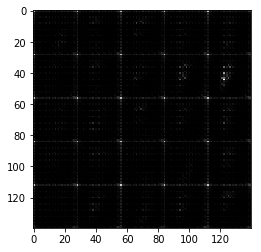

Epoch 1/4... Discriminator Loss: 1.2032... Generator Loss: 1.4029
Epoch 1/4... Discriminator Loss: 1.6123... Generator Loss: 0.5906
Epoch 1/4... Discriminator Loss: 1.4339... Generator Loss: 1.1790
Epoch 1/4... Discriminator Loss: 2.2011... Generator Loss: 0.5087
Epoch 1/4... Discriminator Loss: 0.8295... Generator Loss: 2.0545
Epoch 1/4... Discriminator Loss: 1.1604... Generator Loss: 1.4953
Epoch 1/4... Discriminator Loss: 1.0554... Generator Loss: 1.1531
Epoch 1/4... Discriminator Loss: 1.2070... Generator Loss: 0.8488
Epoch 1/4... Discriminator Loss: 1.4907... Generator Loss: 0.8244
Epoch 1/4... Discriminator Loss: 1.3090... Generator Loss: 0.9224
Epoch 1/4... Discriminator Loss: 1.0990... Generator Loss: 1.5756
Epoch 1/4... Discriminator Loss: 1.2982... Generator Loss: 0.9789
Epoch 1/4... Discriminator Loss: 1.4248... Generator Loss: 0.6491
Epoch 1/4... Discriminator Loss: 1.3204... Generator Loss: 0.8504
Epoch 1/4... Discriminator Loss: 1.5570... Generator Loss: 0.5977


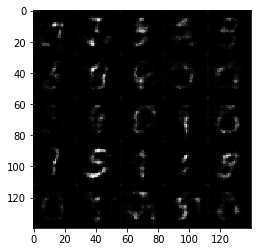

Epoch 1/4... Discriminator Loss: 1.2196... Generator Loss: 1.2453
Epoch 1/4... Discriminator Loss: 1.4062... Generator Loss: 0.6188
Epoch 1/4... Discriminator Loss: 1.4728... Generator Loss: 0.6120
Epoch 1/4... Discriminator Loss: 1.3407... Generator Loss: 0.9153
Epoch 1/4... Discriminator Loss: 1.2264... Generator Loss: 1.0967
Epoch 1/4... Discriminator Loss: 1.7141... Generator Loss: 0.5017
Epoch 1/4... Discriminator Loss: 1.4860... Generator Loss: 1.0074
Epoch 1/4... Discriminator Loss: 1.3783... Generator Loss: 0.8480
Epoch 1/4... Discriminator Loss: 1.3724... Generator Loss: 0.6594
Epoch 1/4... Discriminator Loss: 1.6101... Generator Loss: 0.4543
Epoch 1/4... Discriminator Loss: 1.6048... Generator Loss: 0.6235
Epoch 1/4... Discriminator Loss: 1.3435... Generator Loss: 1.0353
Epoch 1/4... Discriminator Loss: 1.5772... Generator Loss: 0.7569
Epoch 1/4... Discriminator Loss: 1.2677... Generator Loss: 0.7777
Epoch 1/4... Discriminator Loss: 1.1535... Generator Loss: 1.0143


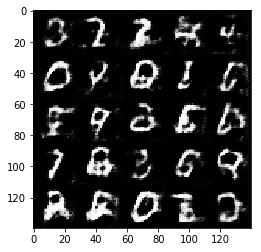

Epoch 1/4... Discriminator Loss: 1.2692... Generator Loss: 0.8382
Epoch 1/4... Discriminator Loss: 1.2507... Generator Loss: 0.9429
Epoch 1/4... Discriminator Loss: 1.4917... Generator Loss: 0.6297
Epoch 1/4... Discriminator Loss: 1.2554... Generator Loss: 0.7778
Epoch 1/4... Discriminator Loss: 1.1398... Generator Loss: 1.1050
Epoch 1/4... Discriminator Loss: 1.6109... Generator Loss: 0.8904
Epoch 1/4... Discriminator Loss: 1.5225... Generator Loss: 0.5608
Epoch 1/4... Discriminator Loss: 1.2321... Generator Loss: 0.9301
Epoch 1/4... Discriminator Loss: 1.3580... Generator Loss: 0.9307
Epoch 1/4... Discriminator Loss: 1.4332... Generator Loss: 0.7048
Epoch 1/4... Discriminator Loss: 1.3993... Generator Loss: 0.7390
Epoch 1/4... Discriminator Loss: 1.2679... Generator Loss: 0.7218
Epoch 1/4... Discriminator Loss: 1.3948... Generator Loss: 0.8042
Epoch 1/4... Discriminator Loss: 1.2494... Generator Loss: 0.8720
Epoch 1/4... Discriminator Loss: 1.4302... Generator Loss: 0.7990


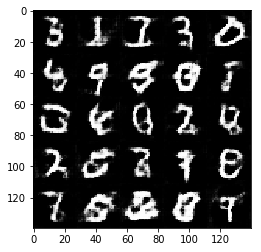

Epoch 1/4... Discriminator Loss: 1.3471... Generator Loss: 0.8096
Epoch 1/4... Discriminator Loss: 1.4667... Generator Loss: 0.7258
Epoch 1/4... Discriminator Loss: 1.3836... Generator Loss: 0.6296
Epoch 1/4... Discriminator Loss: 1.3612... Generator Loss: 0.7637
Epoch 1/4... Discriminator Loss: 1.2396... Generator Loss: 1.1843
Epoch 1/4... Discriminator Loss: 1.2002... Generator Loss: 1.2107
Epoch 1/4... Discriminator Loss: 1.5962... Generator Loss: 0.4910
Epoch 1/4... Discriminator Loss: 1.3403... Generator Loss: 0.9579
Epoch 1/4... Discriminator Loss: 1.4648... Generator Loss: 0.6594
Epoch 1/4... Discriminator Loss: 1.3051... Generator Loss: 1.0672
Epoch 1/4... Discriminator Loss: 1.4501... Generator Loss: 0.6422
Epoch 1/4... Discriminator Loss: 1.3508... Generator Loss: 0.7112
Epoch 1/4... Discriminator Loss: 1.2418... Generator Loss: 0.7536
Epoch 1/4... Discriminator Loss: 1.3535... Generator Loss: 0.8169
Epoch 1/4... Discriminator Loss: 1.2461... Generator Loss: 1.3057


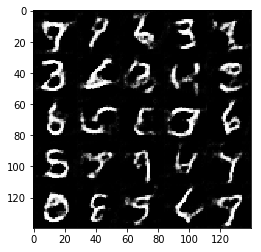

Epoch 1/4... Discriminator Loss: 1.1348... Generator Loss: 1.1634
Epoch 1/4... Discriminator Loss: 1.2358... Generator Loss: 0.8183
Epoch 1/4... Discriminator Loss: 1.2832... Generator Loss: 0.9501
Epoch 1/4... Discriminator Loss: 1.2466... Generator Loss: 0.9555
Epoch 1/4... Discriminator Loss: 1.4408... Generator Loss: 0.7194
Epoch 1/4... Discriminator Loss: 1.1307... Generator Loss: 0.9201
Epoch 1/4... Discriminator Loss: 1.2988... Generator Loss: 0.9243
Epoch 1/4... Discriminator Loss: 1.3444... Generator Loss: 0.6720
Epoch 1/4... Discriminator Loss: 1.1929... Generator Loss: 1.2345
Epoch 1/4... Discriminator Loss: 1.3698... Generator Loss: 0.8465
Epoch 1/4... Discriminator Loss: 1.2378... Generator Loss: 0.8681
Epoch 1/4... Discriminator Loss: 1.1216... Generator Loss: 1.0665
Epoch 1/4... Discriminator Loss: 1.3993... Generator Loss: 0.5368
Epoch 1/4... Discriminator Loss: 1.3538... Generator Loss: 0.6934
Epoch 1/4... Discriminator Loss: 1.1634... Generator Loss: 1.2948


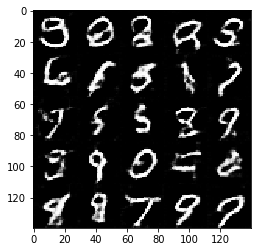

Epoch 1/4... Discriminator Loss: 1.3493... Generator Loss: 1.1754
Epoch 1/4... Discriminator Loss: 1.4388... Generator Loss: 0.9206
Epoch 1/4... Discriminator Loss: 1.3497... Generator Loss: 1.0246
Epoch 1/4... Discriminator Loss: 1.2656... Generator Loss: 1.0557
Epoch 1/4... Discriminator Loss: 1.2404... Generator Loss: 0.9584
Epoch 1/4... Discriminator Loss: 1.2997... Generator Loss: 0.9561
Epoch 1/4... Discriminator Loss: 1.3179... Generator Loss: 0.8705
Epoch 1/4... Discriminator Loss: 1.1577... Generator Loss: 1.1420
Epoch 1/4... Discriminator Loss: 1.3476... Generator Loss: 0.6042
Epoch 1/4... Discriminator Loss: 1.2211... Generator Loss: 0.9572
Epoch 1/4... Discriminator Loss: 1.4635... Generator Loss: 0.8289
Epoch 1/4... Discriminator Loss: 1.2361... Generator Loss: 0.9753
Epoch 1/4... Discriminator Loss: 1.3457... Generator Loss: 1.0821
Epoch 1/4... Discriminator Loss: 1.3080... Generator Loss: 0.8610
Epoch 1/4... Discriminator Loss: 1.2038... Generator Loss: 0.9392


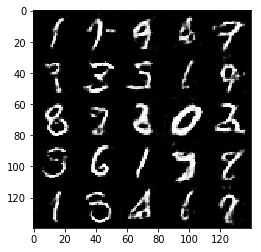

Epoch 1/4... Discriminator Loss: 1.3254... Generator Loss: 1.0412
Epoch 1/4... Discriminator Loss: 1.3807... Generator Loss: 0.7036
Epoch 1/4... Discriminator Loss: 1.4844... Generator Loss: 0.6960
Epoch 1/4... Discriminator Loss: 1.2181... Generator Loss: 0.7247
Epoch 1/4... Discriminator Loss: 1.4450... Generator Loss: 0.6301
Epoch 1/4... Discriminator Loss: 1.3009... Generator Loss: 0.9209
Epoch 1/4... Discriminator Loss: 1.2467... Generator Loss: 1.1867
Epoch 1/4... Discriminator Loss: 1.4024... Generator Loss: 0.6268
Epoch 1/4... Discriminator Loss: 1.3383... Generator Loss: 0.8827
Epoch 1/4... Discriminator Loss: 1.2309... Generator Loss: 1.0383
Epoch 1/4... Discriminator Loss: 1.0212... Generator Loss: 1.0660
Epoch 1/4... Discriminator Loss: 1.2638... Generator Loss: 0.9608
Epoch 1/4... Discriminator Loss: 1.3004... Generator Loss: 1.2528
Epoch 1/4... Discriminator Loss: 1.2151... Generator Loss: 0.8969
Epoch 1/4... Discriminator Loss: 1.1381... Generator Loss: 0.8924


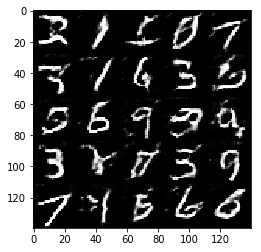

Epoch 1/4... Discriminator Loss: 1.1216... Generator Loss: 1.2594
Epoch 1/4... Discriminator Loss: 1.2726... Generator Loss: 1.6512
Epoch 1/4... Discriminator Loss: 1.3723... Generator Loss: 0.8375
Epoch 1/4... Discriminator Loss: 1.2920... Generator Loss: 1.1304
Epoch 1/4... Discriminator Loss: 1.2301... Generator Loss: 0.9784
Epoch 1/4... Discriminator Loss: 1.1463... Generator Loss: 0.8047
Epoch 1/4... Discriminator Loss: 1.3181... Generator Loss: 0.9050
Epoch 1/4... Discriminator Loss: 1.0626... Generator Loss: 1.2074
Epoch 1/4... Discriminator Loss: 1.3326... Generator Loss: 0.8264
Epoch 1/4... Discriminator Loss: 1.1917... Generator Loss: 0.8583
Epoch 1/4... Discriminator Loss: 1.1924... Generator Loss: 0.9893
Epoch 1/4... Discriminator Loss: 1.2523... Generator Loss: 0.9045
Epoch 1/4... Discriminator Loss: 1.2864... Generator Loss: 0.8014
Epoch 1/4... Discriminator Loss: 1.1959... Generator Loss: 1.3636
Epoch 1/4... Discriminator Loss: 1.1697... Generator Loss: 1.0892


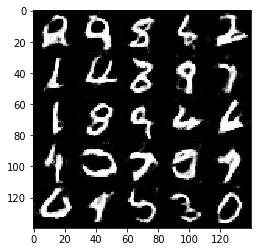

Epoch 1/4... Discriminator Loss: 1.2917... Generator Loss: 0.7281
Epoch 1/4... Discriminator Loss: 1.4182... Generator Loss: 0.6668
Epoch 1/4... Discriminator Loss: 1.2548... Generator Loss: 0.9276
Epoch 1/4... Discriminator Loss: 1.2086... Generator Loss: 1.0009
Epoch 1/4... Discriminator Loss: 1.2749... Generator Loss: 0.8431
Epoch 1/4... Discriminator Loss: 1.0667... Generator Loss: 1.1575
Epoch 1/4... Discriminator Loss: 1.1871... Generator Loss: 0.7939
Epoch 1/4... Discriminator Loss: 1.1761... Generator Loss: 0.8644
Epoch 1/4... Discriminator Loss: 1.2746... Generator Loss: 0.8496
Epoch 1/4... Discriminator Loss: 1.3413... Generator Loss: 0.6684
Epoch 1/4... Discriminator Loss: 1.2139... Generator Loss: 0.9489
Epoch 1/4... Discriminator Loss: 1.6009... Generator Loss: 0.5576
Epoch 1/4... Discriminator Loss: 1.4433... Generator Loss: 0.5413
Epoch 1/4... Discriminator Loss: 1.5634... Generator Loss: 1.2966
Epoch 1/4... Discriminator Loss: 1.3329... Generator Loss: 0.8561


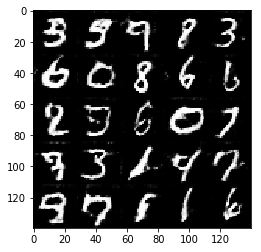

Epoch 1/4... Discriminator Loss: 1.6751... Generator Loss: 0.4516
Epoch 1/4... Discriminator Loss: 1.1912... Generator Loss: 1.1599
Epoch 1/4... Discriminator Loss: 1.1172... Generator Loss: 0.9955
Epoch 1/4... Discriminator Loss: 1.2061... Generator Loss: 0.8633
Epoch 1/4... Discriminator Loss: 1.1248... Generator Loss: 1.0352
Epoch 1/4... Discriminator Loss: 1.1692... Generator Loss: 1.0461
Epoch 1/4... Discriminator Loss: 1.3799... Generator Loss: 0.9402
Epoch 1/4... Discriminator Loss: 1.1677... Generator Loss: 0.9980
Epoch 1/4... Discriminator Loss: 1.1062... Generator Loss: 1.1009
Epoch 1/4... Discriminator Loss: 1.2061... Generator Loss: 0.9761
Epoch 1/4... Discriminator Loss: 1.3293... Generator Loss: 0.9602
Epoch 1/4... Discriminator Loss: 1.1437... Generator Loss: 1.0004
Epoch 1/4... Discriminator Loss: 1.2409... Generator Loss: 1.1859
Epoch 1/4... Discriminator Loss: 1.2496... Generator Loss: 1.1231
Epoch 1/4... Discriminator Loss: 1.0600... Generator Loss: 1.1676


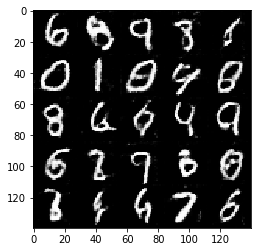

Epoch 1/4... Discriminator Loss: 1.2822... Generator Loss: 0.8109
Epoch 1/4... Discriminator Loss: 1.3692... Generator Loss: 0.7970
Epoch 1/4... Discriminator Loss: 1.0760... Generator Loss: 1.1973
Epoch 1/4... Discriminator Loss: 1.3696... Generator Loss: 0.6376
Epoch 1/4... Discriminator Loss: 1.4001... Generator Loss: 0.6433
Epoch 1/4... Discriminator Loss: 1.1768... Generator Loss: 0.9484
Epoch 1/4... Discriminator Loss: 1.0879... Generator Loss: 0.9637
Epoch 1/4... Discriminator Loss: 1.2176... Generator Loss: 1.1404
Epoch 1/4... Discriminator Loss: 1.2802... Generator Loss: 0.6288
Epoch 1/4... Discriminator Loss: 1.1570... Generator Loss: 0.9503
Epoch 1/4... Discriminator Loss: 1.4170... Generator Loss: 0.8038
Epoch 1/4... Discriminator Loss: 1.3866... Generator Loss: 0.7495
Epoch 1/4... Discriminator Loss: 1.2264... Generator Loss: 0.8566
Epoch 1/4... Discriminator Loss: 1.3457... Generator Loss: 1.3267
Epoch 1/4... Discriminator Loss: 1.0589... Generator Loss: 1.2304


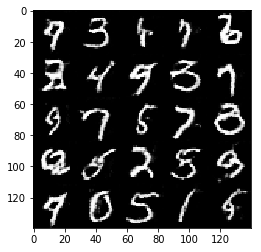

Epoch 1/4... Discriminator Loss: 1.2534... Generator Loss: 0.7920
Epoch 1/4... Discriminator Loss: 1.3098... Generator Loss: 1.0317
Epoch 1/4... Discriminator Loss: 1.5729... Generator Loss: 0.4336
Epoch 1/4... Discriminator Loss: 1.2635... Generator Loss: 0.7365
Epoch 1/4... Discriminator Loss: 1.2412... Generator Loss: 0.7024
Epoch 1/4... Discriminator Loss: 1.3380... Generator Loss: 0.6725
Epoch 1/4... Discriminator Loss: 0.9625... Generator Loss: 1.2207
Epoch 2/4... Discriminator Loss: 1.4039... Generator Loss: 0.9440
Epoch 2/4... Discriminator Loss: 1.2017... Generator Loss: 1.0414
Epoch 2/4... Discriminator Loss: 1.2231... Generator Loss: 0.9961
Epoch 2/4... Discriminator Loss: 1.2475... Generator Loss: 0.8319
Epoch 2/4... Discriminator Loss: 1.1480... Generator Loss: 0.7651
Epoch 2/4... Discriminator Loss: 1.2782... Generator Loss: 0.9262
Epoch 2/4... Discriminator Loss: 1.2233... Generator Loss: 0.8352
Epoch 2/4... Discriminator Loss: 1.1418... Generator Loss: 1.2652


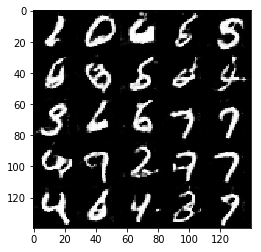

Epoch 2/4... Discriminator Loss: 1.3347... Generator Loss: 0.9204
Epoch 2/4... Discriminator Loss: 1.3748... Generator Loss: 0.8034
Epoch 2/4... Discriminator Loss: 1.3415... Generator Loss: 0.7552
Epoch 2/4... Discriminator Loss: 1.2792... Generator Loss: 0.7704
Epoch 2/4... Discriminator Loss: 1.1361... Generator Loss: 0.9795
Epoch 2/4... Discriminator Loss: 1.2969... Generator Loss: 0.6310
Epoch 2/4... Discriminator Loss: 1.1323... Generator Loss: 1.1953
Epoch 2/4... Discriminator Loss: 1.2972... Generator Loss: 0.7876
Epoch 2/4... Discriminator Loss: 1.1161... Generator Loss: 1.0666
Epoch 2/4... Discriminator Loss: 1.2505... Generator Loss: 0.8586
Epoch 2/4... Discriminator Loss: 1.1150... Generator Loss: 0.8897
Epoch 2/4... Discriminator Loss: 1.1709... Generator Loss: 0.8988
Epoch 2/4... Discriminator Loss: 1.3584... Generator Loss: 0.6908
Epoch 2/4... Discriminator Loss: 1.2448... Generator Loss: 1.2431
Epoch 2/4... Discriminator Loss: 1.2179... Generator Loss: 1.0883


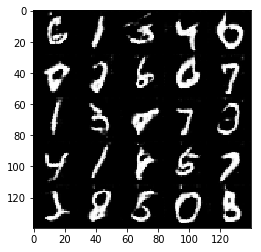

Epoch 2/4... Discriminator Loss: 1.2214... Generator Loss: 1.0944
Epoch 2/4... Discriminator Loss: 1.1590... Generator Loss: 1.0072
Epoch 2/4... Discriminator Loss: 1.1551... Generator Loss: 1.1704
Epoch 2/4... Discriminator Loss: 1.2771... Generator Loss: 1.0007
Epoch 2/4... Discriminator Loss: 1.3556... Generator Loss: 0.5156
Epoch 2/4... Discriminator Loss: 1.0520... Generator Loss: 1.2960
Epoch 2/4... Discriminator Loss: 1.1295... Generator Loss: 1.0775
Epoch 2/4... Discriminator Loss: 1.3151... Generator Loss: 1.1219
Epoch 2/4... Discriminator Loss: 1.0408... Generator Loss: 1.3835
Epoch 2/4... Discriminator Loss: 1.1901... Generator Loss: 0.8926
Epoch 2/4... Discriminator Loss: 1.1434... Generator Loss: 0.9239
Epoch 2/4... Discriminator Loss: 1.1687... Generator Loss: 0.9325
Epoch 2/4... Discriminator Loss: 1.2267... Generator Loss: 0.8595
Epoch 2/4... Discriminator Loss: 0.9677... Generator Loss: 1.1924
Epoch 2/4... Discriminator Loss: 1.4543... Generator Loss: 0.5763


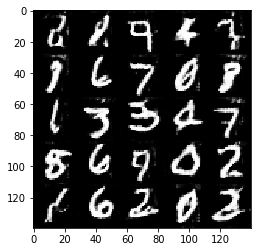

Epoch 2/4... Discriminator Loss: 1.2541... Generator Loss: 0.6520
Epoch 2/4... Discriminator Loss: 1.1615... Generator Loss: 1.0628
Epoch 2/4... Discriminator Loss: 1.2143... Generator Loss: 1.0623
Epoch 2/4... Discriminator Loss: 1.2876... Generator Loss: 1.1874
Epoch 2/4... Discriminator Loss: 1.2545... Generator Loss: 1.2234
Epoch 2/4... Discriminator Loss: 1.3856... Generator Loss: 0.6915
Epoch 2/4... Discriminator Loss: 1.3592... Generator Loss: 0.6290
Epoch 2/4... Discriminator Loss: 1.4155... Generator Loss: 0.7420
Epoch 2/4... Discriminator Loss: 1.0667... Generator Loss: 1.0453
Epoch 2/4... Discriminator Loss: 1.0605... Generator Loss: 1.2810
Epoch 2/4... Discriminator Loss: 1.1890... Generator Loss: 0.9933
Epoch 2/4... Discriminator Loss: 1.2023... Generator Loss: 0.8244
Epoch 2/4... Discriminator Loss: 1.0888... Generator Loss: 1.2574
Epoch 2/4... Discriminator Loss: 1.2194... Generator Loss: 1.2488
Epoch 2/4... Discriminator Loss: 1.2498... Generator Loss: 0.9324


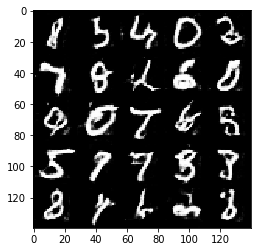

Epoch 2/4... Discriminator Loss: 1.1023... Generator Loss: 0.8791
Epoch 2/4... Discriminator Loss: 1.1327... Generator Loss: 1.0502
Epoch 2/4... Discriminator Loss: 1.1648... Generator Loss: 0.9612
Epoch 2/4... Discriminator Loss: 1.0302... Generator Loss: 1.1881
Epoch 2/4... Discriminator Loss: 1.2571... Generator Loss: 0.9122
Epoch 2/4... Discriminator Loss: 1.1256... Generator Loss: 1.0179
Epoch 2/4... Discriminator Loss: 1.0974... Generator Loss: 1.1777
Epoch 2/4... Discriminator Loss: 1.0979... Generator Loss: 1.0663
Epoch 2/4... Discriminator Loss: 1.0715... Generator Loss: 1.1936
Epoch 2/4... Discriminator Loss: 1.2343... Generator Loss: 1.0531
Epoch 2/4... Discriminator Loss: 1.2984... Generator Loss: 0.7991
Epoch 2/4... Discriminator Loss: 1.1379... Generator Loss: 1.4269
Epoch 2/4... Discriminator Loss: 1.5107... Generator Loss: 0.4956
Epoch 2/4... Discriminator Loss: 1.1148... Generator Loss: 0.8442
Epoch 2/4... Discriminator Loss: 1.2514... Generator Loss: 0.6627


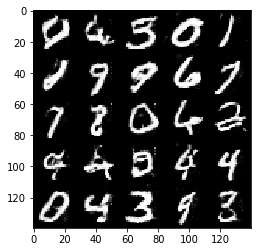

Epoch 2/4... Discriminator Loss: 1.0554... Generator Loss: 1.0903
Epoch 2/4... Discriminator Loss: 1.2048... Generator Loss: 0.7840
Epoch 2/4... Discriminator Loss: 0.9775... Generator Loss: 1.2819
Epoch 2/4... Discriminator Loss: 1.2982... Generator Loss: 0.8161
Epoch 2/4... Discriminator Loss: 1.1655... Generator Loss: 0.8161
Epoch 2/4... Discriminator Loss: 1.2311... Generator Loss: 0.7144
Epoch 2/4... Discriminator Loss: 1.0483... Generator Loss: 1.0393
Epoch 2/4... Discriminator Loss: 1.2873... Generator Loss: 0.9528
Epoch 2/4... Discriminator Loss: 1.5281... Generator Loss: 0.5616
Epoch 2/4... Discriminator Loss: 1.1345... Generator Loss: 0.9430
Epoch 2/4... Discriminator Loss: 1.3179... Generator Loss: 0.9456
Epoch 2/4... Discriminator Loss: 1.2089... Generator Loss: 0.9180
Epoch 2/4... Discriminator Loss: 1.0368... Generator Loss: 1.1635
Epoch 2/4... Discriminator Loss: 1.4154... Generator Loss: 0.6659
Epoch 2/4... Discriminator Loss: 1.2706... Generator Loss: 1.0950


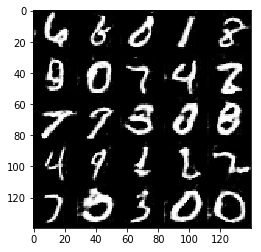

Epoch 2/4... Discriminator Loss: 1.0347... Generator Loss: 1.2552
Epoch 2/4... Discriminator Loss: 1.2047... Generator Loss: 1.1014
Epoch 2/4... Discriminator Loss: 1.3410... Generator Loss: 0.7964
Epoch 2/4... Discriminator Loss: 1.0605... Generator Loss: 1.0682
Epoch 2/4... Discriminator Loss: 1.1153... Generator Loss: 1.2135
Epoch 2/4... Discriminator Loss: 1.1269... Generator Loss: 1.0562
Epoch 2/4... Discriminator Loss: 1.0151... Generator Loss: 1.3163
Epoch 2/4... Discriminator Loss: 1.0279... Generator Loss: 1.3942
Epoch 2/4... Discriminator Loss: 1.5559... Generator Loss: 1.9435
Epoch 2/4... Discriminator Loss: 1.4566... Generator Loss: 0.5823
Epoch 2/4... Discriminator Loss: 1.1184... Generator Loss: 1.3378
Epoch 2/4... Discriminator Loss: 1.1874... Generator Loss: 0.8681
Epoch 2/4... Discriminator Loss: 0.9932... Generator Loss: 1.2062
Epoch 2/4... Discriminator Loss: 1.2015... Generator Loss: 0.8202
Epoch 2/4... Discriminator Loss: 1.4280... Generator Loss: 0.4959


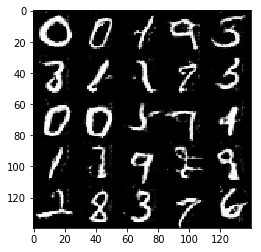

Epoch 2/4... Discriminator Loss: 1.4841... Generator Loss: 0.6372
Epoch 2/4... Discriminator Loss: 1.3907... Generator Loss: 0.7182
Epoch 2/4... Discriminator Loss: 1.0038... Generator Loss: 1.0278
Epoch 2/4... Discriminator Loss: 1.0700... Generator Loss: 0.8830
Epoch 2/4... Discriminator Loss: 0.9924... Generator Loss: 1.0011
Epoch 2/4... Discriminator Loss: 1.0573... Generator Loss: 1.2008
Epoch 2/4... Discriminator Loss: 1.2228... Generator Loss: 0.7179
Epoch 2/4... Discriminator Loss: 1.0714... Generator Loss: 0.9559
Epoch 2/4... Discriminator Loss: 1.3309... Generator Loss: 0.7403
Epoch 2/4... Discriminator Loss: 1.0943... Generator Loss: 0.9736
Epoch 2/4... Discriminator Loss: 1.0644... Generator Loss: 1.0000
Epoch 2/4... Discriminator Loss: 1.1341... Generator Loss: 1.0296
Epoch 2/4... Discriminator Loss: 1.4381... Generator Loss: 0.6543
Epoch 2/4... Discriminator Loss: 1.3360... Generator Loss: 1.2114
Epoch 2/4... Discriminator Loss: 1.1015... Generator Loss: 1.1740


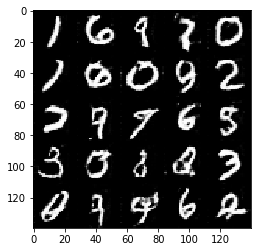

Epoch 2/4... Discriminator Loss: 1.2109... Generator Loss: 0.8202
Epoch 2/4... Discriminator Loss: 1.0861... Generator Loss: 0.9524
Epoch 2/4... Discriminator Loss: 1.0957... Generator Loss: 1.3365
Epoch 2/4... Discriminator Loss: 1.1934... Generator Loss: 0.7762
Epoch 2/4... Discriminator Loss: 1.0221... Generator Loss: 1.2699
Epoch 2/4... Discriminator Loss: 1.2408... Generator Loss: 1.0182
Epoch 2/4... Discriminator Loss: 0.9542... Generator Loss: 1.1746
Epoch 2/4... Discriminator Loss: 0.8482... Generator Loss: 1.3966
Epoch 2/4... Discriminator Loss: 1.3558... Generator Loss: 0.6079
Epoch 2/4... Discriminator Loss: 1.1504... Generator Loss: 0.8907
Epoch 2/4... Discriminator Loss: 1.1755... Generator Loss: 1.7349
Epoch 2/4... Discriminator Loss: 1.1592... Generator Loss: 0.8641
Epoch 2/4... Discriminator Loss: 1.1062... Generator Loss: 0.9200
Epoch 2/4... Discriminator Loss: 1.1717... Generator Loss: 1.4664
Epoch 2/4... Discriminator Loss: 1.0208... Generator Loss: 0.9855


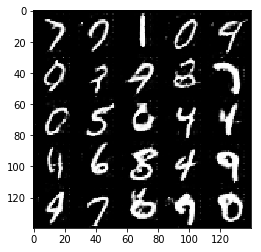

Epoch 2/4... Discriminator Loss: 1.1558... Generator Loss: 1.2794
Epoch 2/4... Discriminator Loss: 1.2932... Generator Loss: 1.5548
Epoch 2/4... Discriminator Loss: 1.2023... Generator Loss: 0.7037
Epoch 2/4... Discriminator Loss: 1.2399... Generator Loss: 1.1230
Epoch 2/4... Discriminator Loss: 1.1343... Generator Loss: 0.7801
Epoch 2/4... Discriminator Loss: 1.0578... Generator Loss: 1.3715
Epoch 2/4... Discriminator Loss: 1.0879... Generator Loss: 0.9050
Epoch 2/4... Discriminator Loss: 1.1963... Generator Loss: 0.8368
Epoch 2/4... Discriminator Loss: 1.4447... Generator Loss: 0.6212
Epoch 2/4... Discriminator Loss: 1.2317... Generator Loss: 1.0723
Epoch 2/4... Discriminator Loss: 1.0454... Generator Loss: 1.2173
Epoch 2/4... Discriminator Loss: 1.1761... Generator Loss: 0.9270
Epoch 2/4... Discriminator Loss: 1.2070... Generator Loss: 0.8014
Epoch 2/4... Discriminator Loss: 1.2339... Generator Loss: 0.9561
Epoch 2/4... Discriminator Loss: 1.1998... Generator Loss: 0.9503


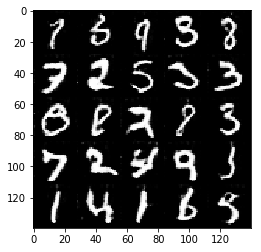

Epoch 2/4... Discriminator Loss: 1.2853... Generator Loss: 0.6411
Epoch 2/4... Discriminator Loss: 1.3808... Generator Loss: 0.6096
Epoch 2/4... Discriminator Loss: 0.9480... Generator Loss: 1.0324
Epoch 2/4... Discriminator Loss: 1.5380... Generator Loss: 0.5708
Epoch 2/4... Discriminator Loss: 1.0907... Generator Loss: 1.0970
Epoch 2/4... Discriminator Loss: 1.2347... Generator Loss: 0.9344
Epoch 2/4... Discriminator Loss: 1.2486... Generator Loss: 0.8261
Epoch 2/4... Discriminator Loss: 1.1885... Generator Loss: 0.7031
Epoch 2/4... Discriminator Loss: 1.0332... Generator Loss: 1.1244
Epoch 2/4... Discriminator Loss: 1.3471... Generator Loss: 0.6430
Epoch 2/4... Discriminator Loss: 1.1910... Generator Loss: 0.9913
Epoch 2/4... Discriminator Loss: 1.1128... Generator Loss: 0.9812
Epoch 2/4... Discriminator Loss: 1.1260... Generator Loss: 0.9896
Epoch 2/4... Discriminator Loss: 1.0414... Generator Loss: 1.0070
Epoch 2/4... Discriminator Loss: 1.0735... Generator Loss: 1.3080


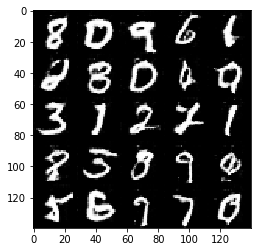

Epoch 2/4... Discriminator Loss: 2.0252... Generator Loss: 0.3460
Epoch 2/4... Discriminator Loss: 1.0237... Generator Loss: 1.2053
Epoch 2/4... Discriminator Loss: 1.2365... Generator Loss: 0.7568
Epoch 2/4... Discriminator Loss: 1.3216... Generator Loss: 2.3102
Epoch 2/4... Discriminator Loss: 1.2568... Generator Loss: 1.0381
Epoch 2/4... Discriminator Loss: 1.2937... Generator Loss: 1.0033
Epoch 2/4... Discriminator Loss: 0.9359... Generator Loss: 1.3425
Epoch 2/4... Discriminator Loss: 1.1037... Generator Loss: 0.9248
Epoch 2/4... Discriminator Loss: 0.9568... Generator Loss: 1.2536
Epoch 2/4... Discriminator Loss: 1.0878... Generator Loss: 1.2130
Epoch 2/4... Discriminator Loss: 1.0573... Generator Loss: 1.0832
Epoch 2/4... Discriminator Loss: 1.0181... Generator Loss: 0.9441
Epoch 2/4... Discriminator Loss: 0.9205... Generator Loss: 1.1249
Epoch 2/4... Discriminator Loss: 1.8704... Generator Loss: 0.3181
Epoch 2/4... Discriminator Loss: 1.0839... Generator Loss: 1.0559


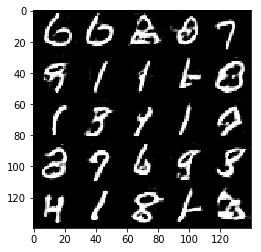

Epoch 2/4... Discriminator Loss: 1.0272... Generator Loss: 1.0760
Epoch 2/4... Discriminator Loss: 1.4851... Generator Loss: 0.7063
Epoch 2/4... Discriminator Loss: 1.1060... Generator Loss: 0.8560
Epoch 2/4... Discriminator Loss: 1.3177... Generator Loss: 0.5396
Epoch 2/4... Discriminator Loss: 1.0850... Generator Loss: 0.7876
Epoch 2/4... Discriminator Loss: 1.1822... Generator Loss: 1.2289
Epoch 2/4... Discriminator Loss: 1.1461... Generator Loss: 1.1969
Epoch 2/4... Discriminator Loss: 1.4185... Generator Loss: 0.6558
Epoch 2/4... Discriminator Loss: 1.4980... Generator Loss: 1.7926
Epoch 2/4... Discriminator Loss: 1.1716... Generator Loss: 0.9710
Epoch 2/4... Discriminator Loss: 1.1797... Generator Loss: 2.2614
Epoch 2/4... Discriminator Loss: 0.9376... Generator Loss: 1.3512
Epoch 2/4... Discriminator Loss: 0.9259... Generator Loss: 1.4010
Epoch 2/4... Discriminator Loss: 1.1384... Generator Loss: 1.2064
Epoch 2/4... Discriminator Loss: 1.1766... Generator Loss: 1.1375


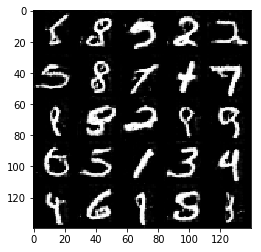

Epoch 3/4... Discriminator Loss: 1.1347... Generator Loss: 1.1396
Epoch 3/4... Discriminator Loss: 1.1482... Generator Loss: 1.0259
Epoch 3/4... Discriminator Loss: 1.1727... Generator Loss: 0.9850
Epoch 3/4... Discriminator Loss: 1.0885... Generator Loss: 0.8777
Epoch 3/4... Discriminator Loss: 1.1712... Generator Loss: 0.6883
Epoch 3/4... Discriminator Loss: 1.0999... Generator Loss: 0.9549
Epoch 3/4... Discriminator Loss: 1.0942... Generator Loss: 0.8219
Epoch 3/4... Discriminator Loss: 1.1174... Generator Loss: 0.8972
Epoch 3/4... Discriminator Loss: 1.0245... Generator Loss: 1.2737
Epoch 3/4... Discriminator Loss: 1.1047... Generator Loss: 1.0515
Epoch 3/4... Discriminator Loss: 1.0252... Generator Loss: 1.1130
Epoch 3/4... Discriminator Loss: 1.2009... Generator Loss: 0.8018
Epoch 3/4... Discriminator Loss: 1.1674... Generator Loss: 0.9304
Epoch 3/4... Discriminator Loss: 1.2182... Generator Loss: 0.7623
Epoch 3/4... Discriminator Loss: 1.0574... Generator Loss: 0.9134


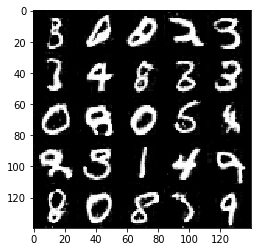

Epoch 3/4... Discriminator Loss: 0.8844... Generator Loss: 1.8126
Epoch 3/4... Discriminator Loss: 1.6355... Generator Loss: 0.4647
Epoch 3/4... Discriminator Loss: 1.3088... Generator Loss: 0.6888
Epoch 3/4... Discriminator Loss: 1.0446... Generator Loss: 0.9272
Epoch 3/4... Discriminator Loss: 1.3330... Generator Loss: 0.6740
Epoch 3/4... Discriminator Loss: 1.7131... Generator Loss: 0.6338
Epoch 3/4... Discriminator Loss: 0.9951... Generator Loss: 1.4140
Epoch 3/4... Discriminator Loss: 1.1198... Generator Loss: 0.9801
Epoch 3/4... Discriminator Loss: 1.0292... Generator Loss: 1.1777
Epoch 3/4... Discriminator Loss: 1.0074... Generator Loss: 0.8237
Epoch 3/4... Discriminator Loss: 1.1784... Generator Loss: 0.7119
Epoch 3/4... Discriminator Loss: 1.3202... Generator Loss: 0.7620
Epoch 3/4... Discriminator Loss: 1.1252... Generator Loss: 1.7992
Epoch 3/4... Discriminator Loss: 1.1263... Generator Loss: 0.9156
Epoch 3/4... Discriminator Loss: 1.0583... Generator Loss: 1.0283


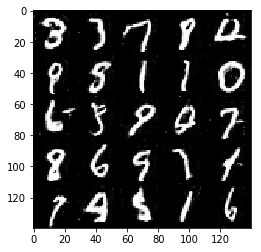

Epoch 3/4... Discriminator Loss: 1.0275... Generator Loss: 1.0142
Epoch 3/4... Discriminator Loss: 1.1512... Generator Loss: 0.7645
Epoch 3/4... Discriminator Loss: 1.1707... Generator Loss: 0.7690
Epoch 3/4... Discriminator Loss: 1.2560... Generator Loss: 0.5930
Epoch 3/4... Discriminator Loss: 0.9386... Generator Loss: 1.0311
Epoch 3/4... Discriminator Loss: 0.9888... Generator Loss: 1.2586
Epoch 3/4... Discriminator Loss: 1.3527... Generator Loss: 1.1462
Epoch 3/4... Discriminator Loss: 1.1949... Generator Loss: 0.7002
Epoch 3/4... Discriminator Loss: 1.1383... Generator Loss: 1.0421
Epoch 3/4... Discriminator Loss: 1.0611... Generator Loss: 1.2181
Epoch 3/4... Discriminator Loss: 1.0726... Generator Loss: 1.2728
Epoch 3/4... Discriminator Loss: 0.9580... Generator Loss: 1.4760
Epoch 3/4... Discriminator Loss: 1.0675... Generator Loss: 1.2176
Epoch 3/4... Discriminator Loss: 1.2847... Generator Loss: 0.6570
Epoch 3/4... Discriminator Loss: 1.0387... Generator Loss: 1.0641


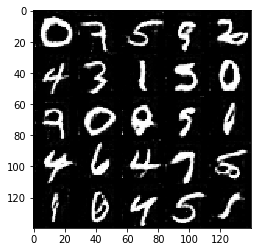

Epoch 3/4... Discriminator Loss: 1.0327... Generator Loss: 0.9953
Epoch 3/4... Discriminator Loss: 0.9444... Generator Loss: 1.2734
Epoch 3/4... Discriminator Loss: 1.1085... Generator Loss: 1.3128
Epoch 3/4... Discriminator Loss: 1.0346... Generator Loss: 1.0381
Epoch 3/4... Discriminator Loss: 1.0648... Generator Loss: 1.1132
Epoch 3/4... Discriminator Loss: 1.2425... Generator Loss: 0.6733
Epoch 3/4... Discriminator Loss: 0.9585... Generator Loss: 1.1875
Epoch 3/4... Discriminator Loss: 1.1438... Generator Loss: 0.7538
Epoch 3/4... Discriminator Loss: 1.3329... Generator Loss: 0.6401
Epoch 3/4... Discriminator Loss: 1.2864... Generator Loss: 0.8245
Epoch 3/4... Discriminator Loss: 1.4851... Generator Loss: 0.5183
Epoch 3/4... Discriminator Loss: 1.3175... Generator Loss: 1.3122
Epoch 3/4... Discriminator Loss: 1.0642... Generator Loss: 1.2389
Epoch 3/4... Discriminator Loss: 1.2954... Generator Loss: 0.8216
Epoch 3/4... Discriminator Loss: 1.1689... Generator Loss: 0.8709


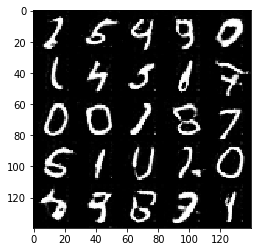

Epoch 3/4... Discriminator Loss: 1.5278... Generator Loss: 0.5850
Epoch 3/4... Discriminator Loss: 1.2636... Generator Loss: 0.7941
Epoch 3/4... Discriminator Loss: 1.0732... Generator Loss: 1.0654
Epoch 3/4... Discriminator Loss: 1.2232... Generator Loss: 1.0589
Epoch 3/4... Discriminator Loss: 1.0102... Generator Loss: 1.1213
Epoch 3/4... Discriminator Loss: 1.3864... Generator Loss: 0.8233
Epoch 3/4... Discriminator Loss: 1.5705... Generator Loss: 1.1983
Epoch 3/4... Discriminator Loss: 1.3093... Generator Loss: 0.7531
Epoch 3/4... Discriminator Loss: 1.1555... Generator Loss: 0.8513
Epoch 3/4... Discriminator Loss: 1.1328... Generator Loss: 0.9465
Epoch 3/4... Discriminator Loss: 0.9987... Generator Loss: 1.1116
Epoch 3/4... Discriminator Loss: 0.9792... Generator Loss: 1.3446
Epoch 3/4... Discriminator Loss: 1.2138... Generator Loss: 0.8814
Epoch 3/4... Discriminator Loss: 1.0681... Generator Loss: 1.3835
Epoch 3/4... Discriminator Loss: 1.1429... Generator Loss: 0.8531


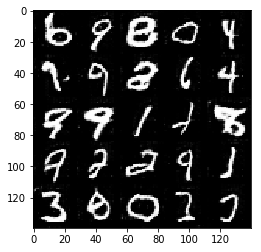

Epoch 3/4... Discriminator Loss: 0.8267... Generator Loss: 2.0151
Epoch 3/4... Discriminator Loss: 1.0366... Generator Loss: 1.0750
Epoch 3/4... Discriminator Loss: 1.3801... Generator Loss: 0.8031
Epoch 3/4... Discriminator Loss: 1.2203... Generator Loss: 1.0018
Epoch 3/4... Discriminator Loss: 1.0714... Generator Loss: 1.0605
Epoch 3/4... Discriminator Loss: 1.1395... Generator Loss: 0.9068
Epoch 3/4... Discriminator Loss: 1.4207... Generator Loss: 0.5743
Epoch 3/4... Discriminator Loss: 1.1377... Generator Loss: 1.1198
Epoch 3/4... Discriminator Loss: 1.0828... Generator Loss: 1.0430
Epoch 3/4... Discriminator Loss: 0.9938... Generator Loss: 1.1096
Epoch 3/4... Discriminator Loss: 1.3987... Generator Loss: 0.8472
Epoch 3/4... Discriminator Loss: 1.1258... Generator Loss: 1.4605
Epoch 3/4... Discriminator Loss: 1.5822... Generator Loss: 0.4813
Epoch 3/4... Discriminator Loss: 0.9210... Generator Loss: 1.2318
Epoch 3/4... Discriminator Loss: 1.0480... Generator Loss: 0.9268


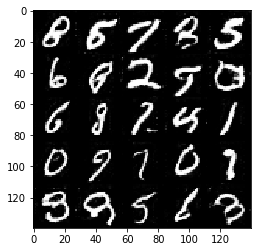

Epoch 3/4... Discriminator Loss: 1.2191... Generator Loss: 1.5826
Epoch 3/4... Discriminator Loss: 0.8208... Generator Loss: 1.5424
Epoch 3/4... Discriminator Loss: 1.1420... Generator Loss: 1.0975
Epoch 3/4... Discriminator Loss: 1.2433... Generator Loss: 0.9363
Epoch 3/4... Discriminator Loss: 1.1935... Generator Loss: 0.8820
Epoch 3/4... Discriminator Loss: 1.1613... Generator Loss: 1.2576
Epoch 3/4... Discriminator Loss: 1.1437... Generator Loss: 1.0851
Epoch 3/4... Discriminator Loss: 1.1996... Generator Loss: 1.0423
Epoch 3/4... Discriminator Loss: 1.3043... Generator Loss: 0.7360
Epoch 3/4... Discriminator Loss: 1.0293... Generator Loss: 1.6189
Epoch 3/4... Discriminator Loss: 1.1295... Generator Loss: 1.0345
Epoch 3/4... Discriminator Loss: 1.0637... Generator Loss: 1.0513
Epoch 3/4... Discriminator Loss: 1.0976... Generator Loss: 1.1858
Epoch 3/4... Discriminator Loss: 1.2526... Generator Loss: 0.9184
Epoch 3/4... Discriminator Loss: 1.8048... Generator Loss: 0.4929


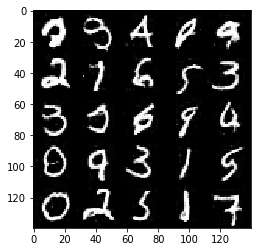

Epoch 3/4... Discriminator Loss: 1.5913... Generator Loss: 0.7674
Epoch 3/4... Discriminator Loss: 1.2100... Generator Loss: 0.8289
Epoch 3/4... Discriminator Loss: 1.5645... Generator Loss: 0.7174
Epoch 3/4... Discriminator Loss: 1.0588... Generator Loss: 1.0533
Epoch 3/4... Discriminator Loss: 1.0866... Generator Loss: 1.1273
Epoch 3/4... Discriminator Loss: 1.2237... Generator Loss: 0.9007
Epoch 3/4... Discriminator Loss: 0.9469... Generator Loss: 1.2354
Epoch 3/4... Discriminator Loss: 0.9652... Generator Loss: 1.1536
Epoch 3/4... Discriminator Loss: 1.0357... Generator Loss: 1.2248
Epoch 3/4... Discriminator Loss: 0.9624... Generator Loss: 1.2680
Epoch 3/4... Discriminator Loss: 0.9986... Generator Loss: 0.9858
Epoch 3/4... Discriminator Loss: 2.6572... Generator Loss: 0.2431
Epoch 3/4... Discriminator Loss: 1.0129... Generator Loss: 1.0475
Epoch 3/4... Discriminator Loss: 0.9570... Generator Loss: 1.0745
Epoch 3/4... Discriminator Loss: 1.1432... Generator Loss: 0.9093


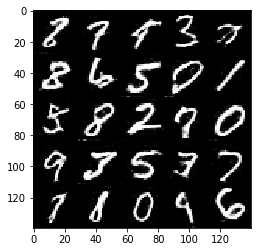

Epoch 3/4... Discriminator Loss: 1.0258... Generator Loss: 1.0107
Epoch 3/4... Discriminator Loss: 1.2409... Generator Loss: 1.0035
Epoch 3/4... Discriminator Loss: 1.1761... Generator Loss: 0.8524
Epoch 3/4... Discriminator Loss: 1.7215... Generator Loss: 0.4488
Epoch 3/4... Discriminator Loss: 1.1208... Generator Loss: 1.2409
Epoch 3/4... Discriminator Loss: 0.8893... Generator Loss: 1.1051
Epoch 3/4... Discriminator Loss: 1.2571... Generator Loss: 0.7655
Epoch 3/4... Discriminator Loss: 0.9434... Generator Loss: 1.2351
Epoch 3/4... Discriminator Loss: 1.1173... Generator Loss: 1.2945
Epoch 3/4... Discriminator Loss: 1.1967... Generator Loss: 0.8587
Epoch 3/4... Discriminator Loss: 0.7901... Generator Loss: 1.2751
Epoch 3/4... Discriminator Loss: 1.3350... Generator Loss: 0.8186
Epoch 3/4... Discriminator Loss: 1.5959... Generator Loss: 0.4366
Epoch 3/4... Discriminator Loss: 0.9584... Generator Loss: 1.4576
Epoch 3/4... Discriminator Loss: 1.0465... Generator Loss: 0.9922


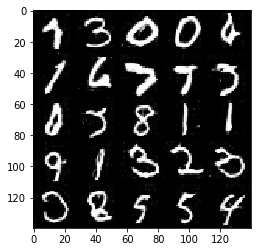

Epoch 3/4... Discriminator Loss: 1.3292... Generator Loss: 0.6452
Epoch 3/4... Discriminator Loss: 1.0836... Generator Loss: 1.0745
Epoch 3/4... Discriminator Loss: 1.1254... Generator Loss: 0.9628
Epoch 3/4... Discriminator Loss: 0.9264... Generator Loss: 1.0235
Epoch 3/4... Discriminator Loss: 1.3751... Generator Loss: 1.2321
Epoch 3/4... Discriminator Loss: 0.9716... Generator Loss: 1.2008
Epoch 3/4... Discriminator Loss: 1.0244... Generator Loss: 1.5240
Epoch 3/4... Discriminator Loss: 1.0208... Generator Loss: 0.9813
Epoch 3/4... Discriminator Loss: 1.2204... Generator Loss: 1.0038
Epoch 3/4... Discriminator Loss: 0.9172... Generator Loss: 1.2385
Epoch 3/4... Discriminator Loss: 1.4012... Generator Loss: 1.3060
Epoch 3/4... Discriminator Loss: 1.1744... Generator Loss: 1.0204
Epoch 3/4... Discriminator Loss: 1.1363... Generator Loss: 1.3011
Epoch 3/4... Discriminator Loss: 1.0890... Generator Loss: 1.1307
Epoch 3/4... Discriminator Loss: 1.2943... Generator Loss: 0.8526


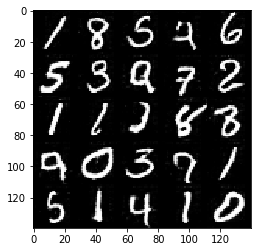

Epoch 3/4... Discriminator Loss: 1.3709... Generator Loss: 0.6528
Epoch 3/4... Discriminator Loss: 1.1578... Generator Loss: 0.8729
Epoch 3/4... Discriminator Loss: 1.0587... Generator Loss: 1.2410
Epoch 3/4... Discriminator Loss: 1.1256... Generator Loss: 1.1429
Epoch 3/4... Discriminator Loss: 0.9457... Generator Loss: 1.3422
Epoch 3/4... Discriminator Loss: 1.0448... Generator Loss: 1.2335
Epoch 3/4... Discriminator Loss: 0.9648... Generator Loss: 1.5340
Epoch 3/4... Discriminator Loss: 1.2356... Generator Loss: 0.9149
Epoch 3/4... Discriminator Loss: 1.1192... Generator Loss: 1.0243
Epoch 3/4... Discriminator Loss: 1.1744... Generator Loss: 1.2488
Epoch 3/4... Discriminator Loss: 1.3746... Generator Loss: 1.5852
Epoch 3/4... Discriminator Loss: 1.4368... Generator Loss: 0.7676
Epoch 3/4... Discriminator Loss: 1.1090... Generator Loss: 1.1965
Epoch 3/4... Discriminator Loss: 1.1106... Generator Loss: 0.9905
Epoch 3/4... Discriminator Loss: 1.0674... Generator Loss: 1.3115


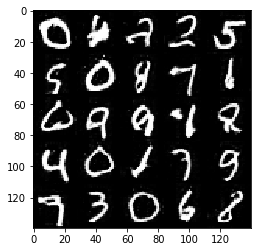

Epoch 3/4... Discriminator Loss: 1.2732... Generator Loss: 0.7241
Epoch 3/4... Discriminator Loss: 1.3702... Generator Loss: 0.6977
Epoch 3/4... Discriminator Loss: 0.8009... Generator Loss: 1.6979
Epoch 3/4... Discriminator Loss: 1.5160... Generator Loss: 0.6650
Epoch 3/4... Discriminator Loss: 1.2382... Generator Loss: 0.7306
Epoch 3/4... Discriminator Loss: 1.2605... Generator Loss: 0.9422
Epoch 3/4... Discriminator Loss: 1.3526... Generator Loss: 0.6671
Epoch 3/4... Discriminator Loss: 1.1848... Generator Loss: 1.1762
Epoch 3/4... Discriminator Loss: 1.1009... Generator Loss: 1.1579
Epoch 3/4... Discriminator Loss: 1.0114... Generator Loss: 1.1797
Epoch 3/4... Discriminator Loss: 1.0391... Generator Loss: 0.9518
Epoch 3/4... Discriminator Loss: 1.1647... Generator Loss: 1.0940
Epoch 3/4... Discriminator Loss: 1.0146... Generator Loss: 1.3026
Epoch 3/4... Discriminator Loss: 1.1494... Generator Loss: 1.0260
Epoch 3/4... Discriminator Loss: 1.0607... Generator Loss: 0.9812


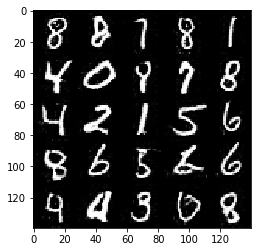

Epoch 3/4... Discriminator Loss: 1.1206... Generator Loss: 0.8637
Epoch 3/4... Discriminator Loss: 1.0713... Generator Loss: 1.1890
Epoch 3/4... Discriminator Loss: 1.2291... Generator Loss: 1.3928
Epoch 3/4... Discriminator Loss: 1.0810... Generator Loss: 0.9657
Epoch 3/4... Discriminator Loss: 1.1061... Generator Loss: 1.1072
Epoch 3/4... Discriminator Loss: 1.3868... Generator Loss: 1.0954
Epoch 3/4... Discriminator Loss: 0.9424... Generator Loss: 1.0414
Epoch 4/4... Discriminator Loss: 1.0783... Generator Loss: 1.0406
Epoch 4/4... Discriminator Loss: 0.8952... Generator Loss: 1.9501
Epoch 4/4... Discriminator Loss: 1.0167... Generator Loss: 1.1710
Epoch 4/4... Discriminator Loss: 1.2502... Generator Loss: 1.4601
Epoch 4/4... Discriminator Loss: 1.2249... Generator Loss: 0.6016
Epoch 4/4... Discriminator Loss: 1.1570... Generator Loss: 0.9815
Epoch 4/4... Discriminator Loss: 1.1717... Generator Loss: 1.1296
Epoch 4/4... Discriminator Loss: 1.0866... Generator Loss: 1.3310


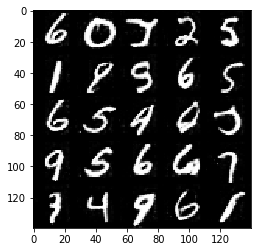

Epoch 4/4... Discriminator Loss: 0.9574... Generator Loss: 1.0630
Epoch 4/4... Discriminator Loss: 1.5503... Generator Loss: 0.7163
Epoch 4/4... Discriminator Loss: 1.2269... Generator Loss: 1.0819
Epoch 4/4... Discriminator Loss: 1.0195... Generator Loss: 0.8410
Epoch 4/4... Discriminator Loss: 1.2074... Generator Loss: 0.7861
Epoch 4/4... Discriminator Loss: 1.1047... Generator Loss: 0.8840
Epoch 4/4... Discriminator Loss: 1.3606... Generator Loss: 0.6125
Epoch 4/4... Discriminator Loss: 1.0465... Generator Loss: 1.0664
Epoch 4/4... Discriminator Loss: 0.8073... Generator Loss: 1.3424
Epoch 4/4... Discriminator Loss: 1.1527... Generator Loss: 1.3844
Epoch 4/4... Discriminator Loss: 1.0225... Generator Loss: 1.2729
Epoch 4/4... Discriminator Loss: 1.2154... Generator Loss: 0.8860
Epoch 4/4... Discriminator Loss: 1.6111... Generator Loss: 0.5502
Epoch 4/4... Discriminator Loss: 0.9388... Generator Loss: 1.2786
Epoch 4/4... Discriminator Loss: 0.9641... Generator Loss: 1.4308


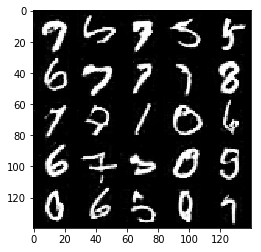

Epoch 4/4... Discriminator Loss: 1.1316... Generator Loss: 1.0487
Epoch 4/4... Discriminator Loss: 1.1033... Generator Loss: 1.0467
Epoch 4/4... Discriminator Loss: 1.1563... Generator Loss: 0.8356
Epoch 4/4... Discriminator Loss: 1.0049... Generator Loss: 1.2431
Epoch 4/4... Discriminator Loss: 1.0444... Generator Loss: 1.1704
Epoch 4/4... Discriminator Loss: 1.0593... Generator Loss: 1.2866
Epoch 4/4... Discriminator Loss: 1.2447... Generator Loss: 1.0109
Epoch 4/4... Discriminator Loss: 0.8992... Generator Loss: 1.5302
Epoch 4/4... Discriminator Loss: 0.9297... Generator Loss: 1.3781
Epoch 4/4... Discriminator Loss: 1.1497... Generator Loss: 0.8957
Epoch 4/4... Discriminator Loss: 1.2212... Generator Loss: 0.7389
Epoch 4/4... Discriminator Loss: 1.0419... Generator Loss: 0.9295
Epoch 4/4... Discriminator Loss: 1.2676... Generator Loss: 0.9650
Epoch 4/4... Discriminator Loss: 1.1827... Generator Loss: 0.9402
Epoch 4/4... Discriminator Loss: 1.1995... Generator Loss: 0.6375


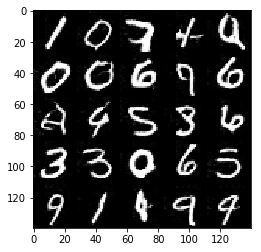

Epoch 4/4... Discriminator Loss: 0.9755... Generator Loss: 1.3197
Epoch 4/4... Discriminator Loss: 1.4637... Generator Loss: 0.8511
Epoch 4/4... Discriminator Loss: 1.1962... Generator Loss: 0.8113
Epoch 4/4... Discriminator Loss: 1.1995... Generator Loss: 1.4136
Epoch 4/4... Discriminator Loss: 1.0752... Generator Loss: 1.1747
Epoch 4/4... Discriminator Loss: 1.2429... Generator Loss: 1.1306
Epoch 4/4... Discriminator Loss: 1.0417... Generator Loss: 0.9830
Epoch 4/4... Discriminator Loss: 1.3848... Generator Loss: 2.0199
Epoch 4/4... Discriminator Loss: 0.9235... Generator Loss: 1.9893
Epoch 4/4... Discriminator Loss: 1.0430... Generator Loss: 2.2943
Epoch 4/4... Discriminator Loss: 1.3407... Generator Loss: 0.7117
Epoch 4/4... Discriminator Loss: 0.9095... Generator Loss: 1.2912
Epoch 4/4... Discriminator Loss: 1.2672... Generator Loss: 1.3122
Epoch 4/4... Discriminator Loss: 0.7072... Generator Loss: 1.6362
Epoch 4/4... Discriminator Loss: 1.1258... Generator Loss: 1.1559


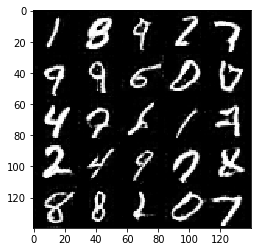

Epoch 4/4... Discriminator Loss: 1.2296... Generator Loss: 0.7256
Epoch 4/4... Discriminator Loss: 1.0595... Generator Loss: 1.1187
Epoch 4/4... Discriminator Loss: 1.3709... Generator Loss: 1.2792
Epoch 4/4... Discriminator Loss: 1.3447... Generator Loss: 0.8604
Epoch 4/4... Discriminator Loss: 1.3278... Generator Loss: 0.8986
Epoch 4/4... Discriminator Loss: 1.4375... Generator Loss: 0.6424
Epoch 4/4... Discriminator Loss: 1.1487... Generator Loss: 1.0675
Epoch 4/4... Discriminator Loss: 1.0494... Generator Loss: 0.9304
Epoch 4/4... Discriminator Loss: 0.9738... Generator Loss: 1.2353
Epoch 4/4... Discriminator Loss: 1.1898... Generator Loss: 1.0510
Epoch 4/4... Discriminator Loss: 1.2040... Generator Loss: 0.8691
Epoch 4/4... Discriminator Loss: 0.9787... Generator Loss: 1.6152
Epoch 4/4... Discriminator Loss: 1.0994... Generator Loss: 0.8566
Epoch 4/4... Discriminator Loss: 2.0283... Generator Loss: 0.4442
Epoch 4/4... Discriminator Loss: 1.0622... Generator Loss: 0.9841


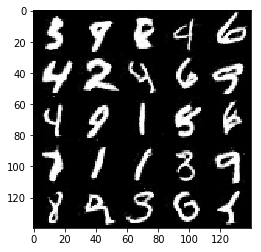

Epoch 4/4... Discriminator Loss: 1.0151... Generator Loss: 1.3712
Epoch 4/4... Discriminator Loss: 1.1178... Generator Loss: 0.8287
Epoch 4/4... Discriminator Loss: 1.2135... Generator Loss: 0.9977
Epoch 4/4... Discriminator Loss: 1.3776... Generator Loss: 0.6720
Epoch 4/4... Discriminator Loss: 1.0865... Generator Loss: 1.3838
Epoch 4/4... Discriminator Loss: 1.1267... Generator Loss: 0.7240
Epoch 4/4... Discriminator Loss: 1.0416... Generator Loss: 1.1928
Epoch 4/4... Discriminator Loss: 1.2297... Generator Loss: 0.7428
Epoch 4/4... Discriminator Loss: 1.2301... Generator Loss: 0.8203
Epoch 4/4... Discriminator Loss: 1.1551... Generator Loss: 0.7458
Epoch 4/4... Discriminator Loss: 1.4028... Generator Loss: 1.8291
Epoch 4/4... Discriminator Loss: 0.9156... Generator Loss: 1.4189
Epoch 4/4... Discriminator Loss: 1.0354... Generator Loss: 1.2272
Epoch 4/4... Discriminator Loss: 1.0146... Generator Loss: 1.0866
Epoch 4/4... Discriminator Loss: 1.3277... Generator Loss: 0.5774


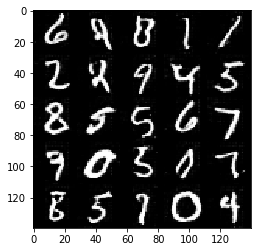

Epoch 4/4... Discriminator Loss: 0.9552... Generator Loss: 1.3137
Epoch 4/4... Discriminator Loss: 1.4159... Generator Loss: 0.7671
Epoch 4/4... Discriminator Loss: 1.8475... Generator Loss: 0.5027
Epoch 4/4... Discriminator Loss: 1.1157... Generator Loss: 1.1632
Epoch 4/4... Discriminator Loss: 0.8759... Generator Loss: 1.4131
Epoch 4/4... Discriminator Loss: 1.1792... Generator Loss: 0.7021
Epoch 4/4... Discriminator Loss: 1.3246... Generator Loss: 0.9432
Epoch 4/4... Discriminator Loss: 1.1202... Generator Loss: 1.5007
Epoch 4/4... Discriminator Loss: 1.0125... Generator Loss: 0.9886
Epoch 4/4... Discriminator Loss: 1.1157... Generator Loss: 1.0116
Epoch 4/4... Discriminator Loss: 1.1355... Generator Loss: 0.9326
Epoch 4/4... Discriminator Loss: 1.0043... Generator Loss: 1.1687
Epoch 4/4... Discriminator Loss: 0.9192... Generator Loss: 1.2152
Epoch 4/4... Discriminator Loss: 1.1268... Generator Loss: 1.6444
Epoch 4/4... Discriminator Loss: 1.4098... Generator Loss: 0.7075


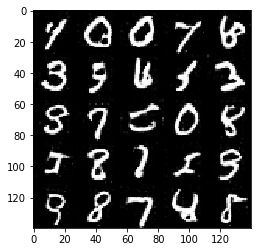

Epoch 4/4... Discriminator Loss: 1.2454... Generator Loss: 0.9903
Epoch 4/4... Discriminator Loss: 1.0255... Generator Loss: 1.0178
Epoch 4/4... Discriminator Loss: 1.0943... Generator Loss: 1.0214
Epoch 4/4... Discriminator Loss: 0.8095... Generator Loss: 1.5179
Epoch 4/4... Discriminator Loss: 1.3779... Generator Loss: 1.3738
Epoch 4/4... Discriminator Loss: 0.9716... Generator Loss: 1.2097
Epoch 4/4... Discriminator Loss: 1.2999... Generator Loss: 0.9457
Epoch 4/4... Discriminator Loss: 1.0595... Generator Loss: 1.2646
Epoch 4/4... Discriminator Loss: 1.0387... Generator Loss: 1.0753
Epoch 4/4... Discriminator Loss: 0.9445... Generator Loss: 1.0037
Epoch 4/4... Discriminator Loss: 1.0390... Generator Loss: 0.9432
Epoch 4/4... Discriminator Loss: 1.4502... Generator Loss: 0.6055
Epoch 4/4... Discriminator Loss: 0.9675... Generator Loss: 1.2779
Epoch 4/4... Discriminator Loss: 1.0849... Generator Loss: 0.9282
Epoch 4/4... Discriminator Loss: 1.2078... Generator Loss: 0.8874


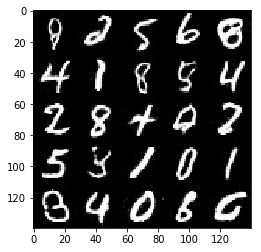

Epoch 4/4... Discriminator Loss: 1.0369... Generator Loss: 1.3694
Epoch 4/4... Discriminator Loss: 1.3553... Generator Loss: 1.6835
Epoch 4/4... Discriminator Loss: 0.9210... Generator Loss: 1.2097
Epoch 4/4... Discriminator Loss: 1.0591... Generator Loss: 0.8786
Epoch 4/4... Discriminator Loss: 1.1313... Generator Loss: 0.8853
Epoch 4/4... Discriminator Loss: 1.3838... Generator Loss: 0.6152
Epoch 4/4... Discriminator Loss: 1.1265... Generator Loss: 1.1456
Epoch 4/4... Discriminator Loss: 1.1752... Generator Loss: 0.9276
Epoch 4/4... Discriminator Loss: 1.5860... Generator Loss: 0.5974
Epoch 4/4... Discriminator Loss: 1.3347... Generator Loss: 0.6860
Epoch 4/4... Discriminator Loss: 1.3262... Generator Loss: 1.0598
Epoch 4/4... Discriminator Loss: 1.1112... Generator Loss: 1.0137
Epoch 4/4... Discriminator Loss: 1.4895... Generator Loss: 0.8532
Epoch 4/4... Discriminator Loss: 0.9768... Generator Loss: 1.2079
Epoch 4/4... Discriminator Loss: 1.0128... Generator Loss: 0.9035


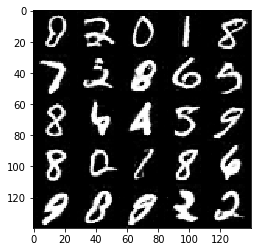

Epoch 4/4... Discriminator Loss: 0.8304... Generator Loss: 1.4685
Epoch 4/4... Discriminator Loss: 1.5041... Generator Loss: 1.4092
Epoch 4/4... Discriminator Loss: 1.4163... Generator Loss: 0.7782
Epoch 4/4... Discriminator Loss: 1.3129... Generator Loss: 0.6387
Epoch 4/4... Discriminator Loss: 1.0931... Generator Loss: 0.9665
Epoch 4/4... Discriminator Loss: 1.0531... Generator Loss: 0.9585
Epoch 4/4... Discriminator Loss: 1.1301... Generator Loss: 1.1741
Epoch 4/4... Discriminator Loss: 1.0917... Generator Loss: 0.9951
Epoch 4/4... Discriminator Loss: 1.1144... Generator Loss: 0.9183
Epoch 4/4... Discriminator Loss: 1.1332... Generator Loss: 0.9137
Epoch 4/4... Discriminator Loss: 1.0352... Generator Loss: 1.7066
Epoch 4/4... Discriminator Loss: 1.4672... Generator Loss: 0.7195
Epoch 4/4... Discriminator Loss: 1.2767... Generator Loss: 0.8329
Epoch 4/4... Discriminator Loss: 1.0146... Generator Loss: 0.9409
Epoch 4/4... Discriminator Loss: 1.1194... Generator Loss: 1.4171


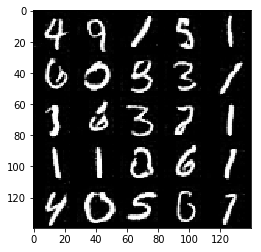

Epoch 4/4... Discriminator Loss: 1.2359... Generator Loss: 0.8631
Epoch 4/4... Discriminator Loss: 1.2695... Generator Loss: 1.2904
Epoch 4/4... Discriminator Loss: 1.1041... Generator Loss: 1.0979
Epoch 4/4... Discriminator Loss: 1.0969... Generator Loss: 1.3088
Epoch 4/4... Discriminator Loss: 1.0404... Generator Loss: 1.2123
Epoch 4/4... Discriminator Loss: 1.0123... Generator Loss: 1.0421
Epoch 4/4... Discriminator Loss: 1.1520... Generator Loss: 0.8931
Epoch 4/4... Discriminator Loss: 1.3835... Generator Loss: 0.6066
Epoch 4/4... Discriminator Loss: 0.8811... Generator Loss: 2.3127
Epoch 4/4... Discriminator Loss: 1.3067... Generator Loss: 0.7990
Epoch 4/4... Discriminator Loss: 1.4354... Generator Loss: 0.7036
Epoch 4/4... Discriminator Loss: 1.0181... Generator Loss: 1.0452
Epoch 4/4... Discriminator Loss: 1.2501... Generator Loss: 1.1311
Epoch 4/4... Discriminator Loss: 1.0338... Generator Loss: 1.2543
Epoch 4/4... Discriminator Loss: 1.4851... Generator Loss: 0.7362


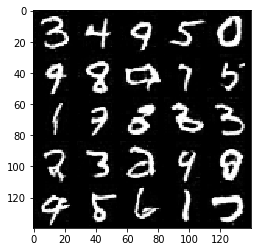

Epoch 4/4... Discriminator Loss: 1.2229... Generator Loss: 0.6652
Epoch 4/4... Discriminator Loss: 0.9287... Generator Loss: 1.3316
Epoch 4/4... Discriminator Loss: 1.0733... Generator Loss: 1.1426
Epoch 4/4... Discriminator Loss: 0.8958... Generator Loss: 1.2454
Epoch 4/4... Discriminator Loss: 1.1300... Generator Loss: 1.3131
Epoch 4/4... Discriminator Loss: 1.2890... Generator Loss: 0.9756
Epoch 4/4... Discriminator Loss: 0.9684... Generator Loss: 1.3600
Epoch 4/4... Discriminator Loss: 0.8524... Generator Loss: 1.5139
Epoch 4/4... Discriminator Loss: 1.0086... Generator Loss: 1.2347
Epoch 4/4... Discriminator Loss: 1.0537... Generator Loss: 1.2398
Epoch 4/4... Discriminator Loss: 1.2917... Generator Loss: 0.7687
Epoch 4/4... Discriminator Loss: 1.0648... Generator Loss: 0.9611
Epoch 4/4... Discriminator Loss: 1.0445... Generator Loss: 1.0435
Epoch 4/4... Discriminator Loss: 1.1660... Generator Loss: 1.1003
Epoch 4/4... Discriminator Loss: 1.0560... Generator Loss: 1.7013


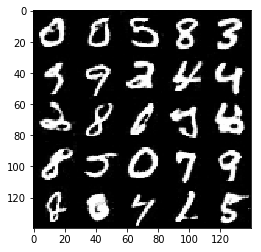

Epoch 4/4... Discriminator Loss: 0.8559... Generator Loss: 1.3713
Epoch 4/4... Discriminator Loss: 1.1640... Generator Loss: 0.9657
Epoch 4/4... Discriminator Loss: 1.0083... Generator Loss: 1.1994
Epoch 4/4... Discriminator Loss: 1.3978... Generator Loss: 0.6721
Epoch 4/4... Discriminator Loss: 0.9602... Generator Loss: 1.0097
Epoch 4/4... Discriminator Loss: 1.3393... Generator Loss: 0.7779
Epoch 4/4... Discriminator Loss: 1.0654... Generator Loss: 0.9052
Epoch 4/4... Discriminator Loss: 1.0647... Generator Loss: 1.0311
Epoch 4/4... Discriminator Loss: 0.9761... Generator Loss: 1.8006
Epoch 4/4... Discriminator Loss: 1.6707... Generator Loss: 0.3957
Epoch 4/4... Discriminator Loss: 1.1074... Generator Loss: 1.0199
Epoch 4/4... Discriminator Loss: 1.2563... Generator Loss: 0.9500
Epoch 4/4... Discriminator Loss: 1.2540... Generator Loss: 0.6917
Epoch 4/4... Discriminator Loss: 1.1149... Generator Loss: 0.9372
Epoch 4/4... Discriminator Loss: 1.0927... Generator Loss: 1.3659


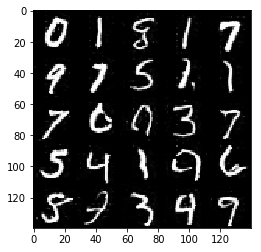

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.4067
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.7105
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.1519
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 4.8100
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 6.1133
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.8873
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 3.1590
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 3.3008
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 3.4775
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.4029


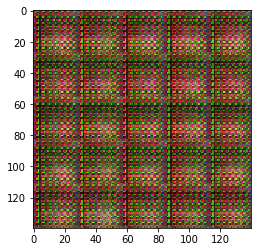

Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 2.1629
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 2.6983
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.7081
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 3.6996
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 2.5422
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.4452
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 4.0084
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 3.1115
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 1.8406
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.6505
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 2.1582
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 5.0656
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 1.6267


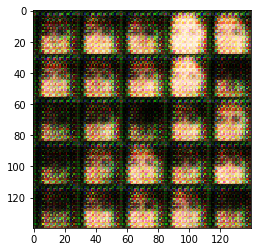

Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 2.3865
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 2.1243
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 2.4042
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.8651
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.6806
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.8082
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 2.3426
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 2.0774


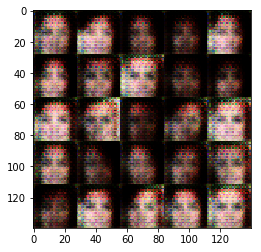

Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 2.1220
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.8909
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 2.3709
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 2.4004
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.9156
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 3.0376
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.5517


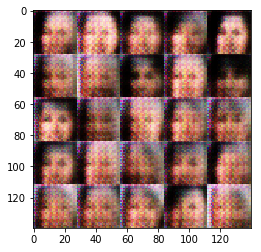

Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 2.6238
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 2.2154
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.9587
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 2.1111
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 2.2403
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 2.7273
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 2.9066
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.9819


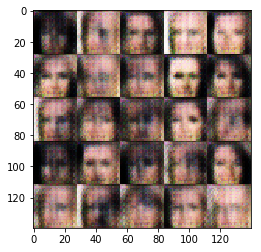

Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.4784
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.4138
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.8620
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.4981
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.7776
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.5704


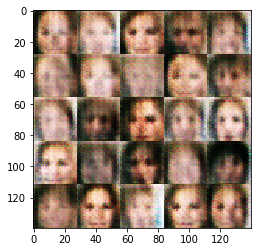

Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.5465
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.8379
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.7740
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.6277
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.2797
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.9514
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.0914


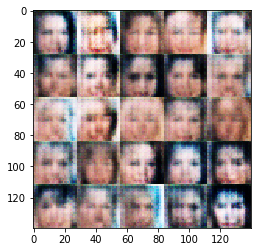

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.4079
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.9810


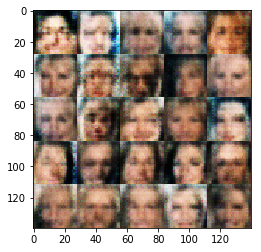

Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.4328
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.9796


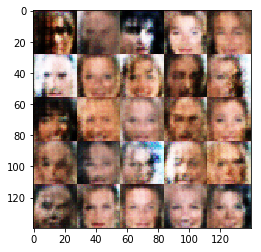

Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.2230
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.2573
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.0852


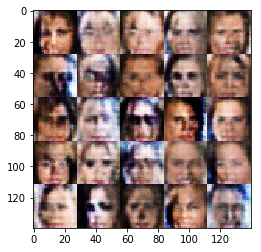

Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8552


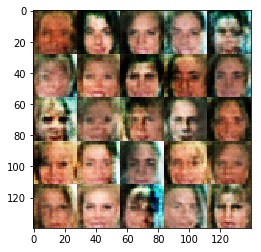

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.1641


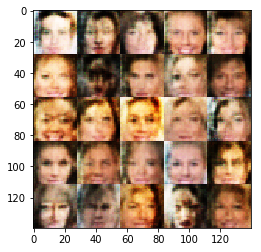

Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.2983


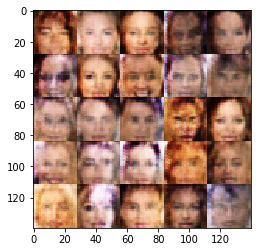

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.1565


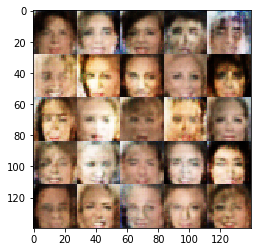

Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.6243
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7374


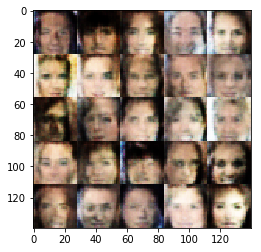

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.8765
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.1109


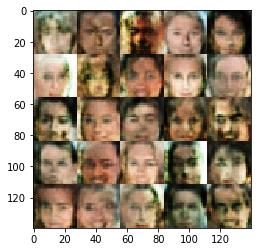

Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.7402... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.8382


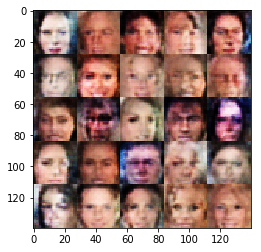

Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.6865
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.4612
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8300


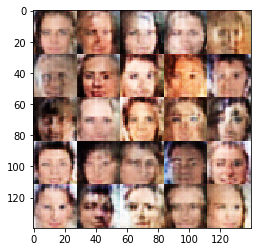

Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7286


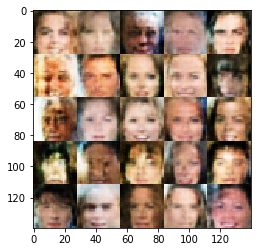

Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.6040
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.1728
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9090


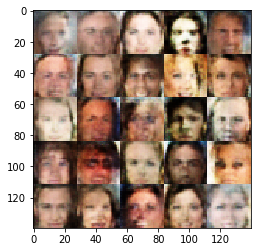

Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.3552
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9177


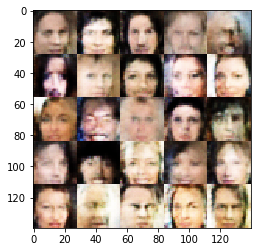

Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.4176
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 1.3406


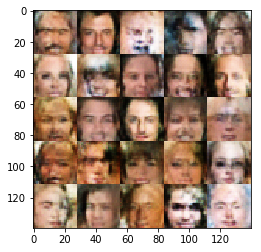

Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.6370... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.3449
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.9323


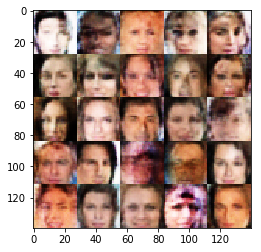

Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.0039


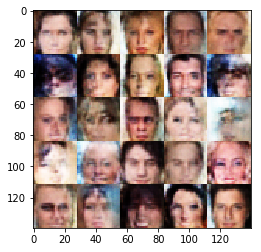

Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.3104
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.9303


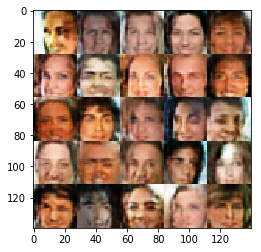

Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9305


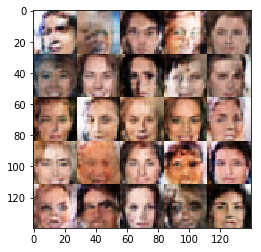

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.8897


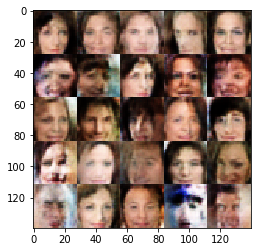

Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8883


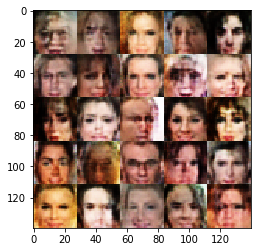

Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.5079
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7797


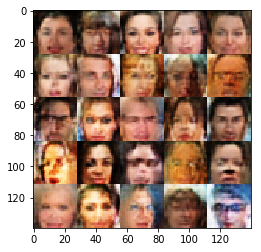

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 2.3851
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8131


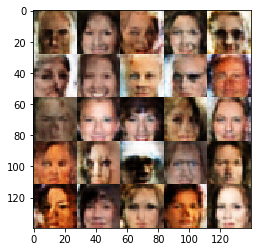

Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.5879
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 1.0270


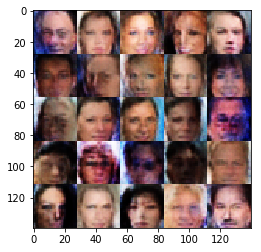

Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.3753


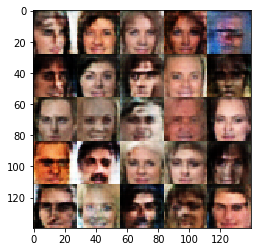

Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8094


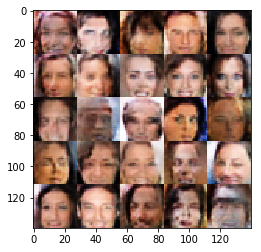

Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.3136
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8169


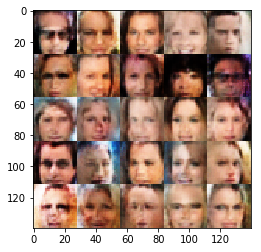

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8266


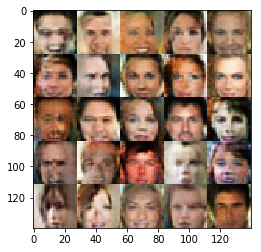

Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.2447


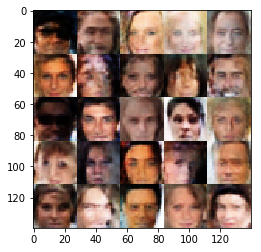

Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.7959


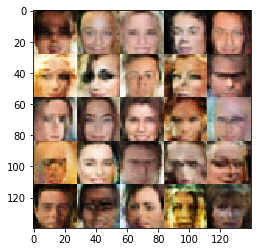

Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 2.1527


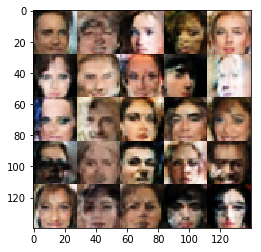

Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6698


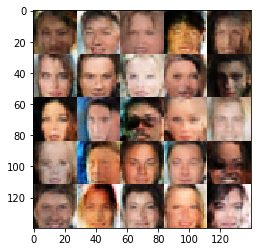

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6065


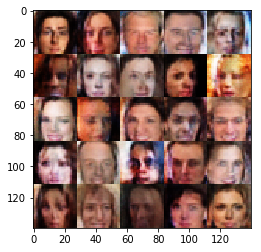

Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.4279
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.3015


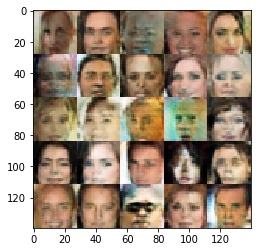

Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.4651
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7044


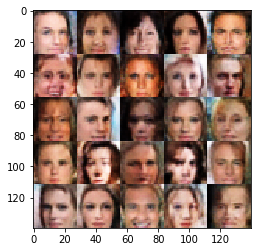

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.5203
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.8643


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.